# Comparison Between Linear Regression and Nearest Neighbor on Predicting Recipe Rating from Macro-Nutrients

Dataset sourced from Kaggle:
https://www.kaggle.com/hugodarwood/epirecipes  

You know what they say:  
**Fat + Salt = Flavor...**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import neighbors
from sklearn import linear_model
pd.options.display.float_format = '{:.3f}'.format
from scipy import stats
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

file = 'C:\\Users\\Abe\\Data Science Bootcamp\\Unit 3\\Recipe Data Set\\epi_r.csv'
df = pd.read_csv(file)

df.head()

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.000,30.000,7.000,559.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.000,18.000,23.000,1439.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,Potato and Fennel Soup Hodge,3.750,165.000,6.000,7.000,165.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,Mahi-Mahi in Tomato Olive Sauce,5.000,nan,nan,nan,nan,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,Spinach Noodle Casserole,3.125,547.000,20.000,32.000,452.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [2]:
# Drop ingredient columns

df = df.iloc[:,:6]
df.head()

,title,rating,calories,protein,fat,sodium
0,"Lentil, Apple, and Turkey Wrap",2.500,426.000,30.000,7.000,559.000
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.000,18.000,23.000,1439.000
2,Potato and Fennel Soup Hodge,3.750,165.000,6.000,7.000,165.000
3,Mahi-Mahi in Tomato Olive Sauce,5.000,nan,nan,nan,nan
4,Spinach Noodle Casserole,3.125,547.000,20.000,32.000,452.000


In [3]:
# Check for null values

print(df.info())
print('\n')
print('Missing Values:')
print(df.isnull().sum())
print('\nShared Missing Values:')
print(df.loc[(df['calories'].isnull()) &
   (df['protein'].isnull()) & 
   (df['fat'].isnull()) &
   (df['sodium'].isnull())
  ].shape[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20052 entries, 0 to 20051
Data columns (total 6 columns):
title       20052 non-null object
rating      20052 non-null float64
calories    15935 non-null float64
protein     15890 non-null float64
fat         15869 non-null float64
sodium      15933 non-null float64
dtypes: float64(5), object(1)
memory usage: 861.6+ KB
None


Missing Values:
title          0
rating         0
calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

Shared Missing Values:
4117


The data contain a lot of null values. Luckily, they are pretty well grouped. I don't see any logical way to fill in the missing values without biasing the models, so I will drop the NaNs.

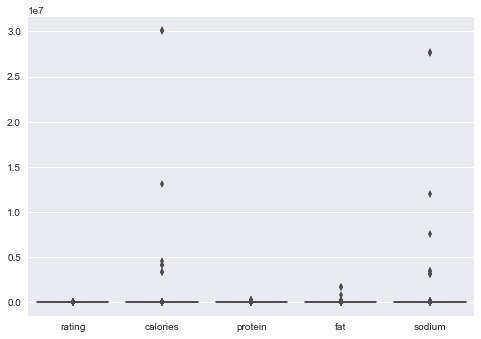

,rating,calories,protein,fat,sodium
count,15864.000,15864.000,15864.000,15864.000,15864.000
mean,3.761,6350.683,100.325,346.987,6252.742
std,1.286,359848.418,3843.462,20459.330,334042.078
min,0.000,0.000,0.000,0.000,0.000
25%,3.750,199.000,3.000,7.000,82.000
50%,4.375,333.000,8.000,17.000,296.000
75%,4.375,587.250,27.000,33.000,713.000
max,5.000,30111218.000,236489.000,1722763.000,27675110.000


In [4]:
# Drop NaNs and look at the distributions
df.dropna(inplace=True)

sns.boxplot(data=df)
plt.show()
df.describe()

The macro nutrient counts on Epicurious come from predictions based on the ingredients and their respective amount in the recipes. It looks like the predictions are erroneous in many cases. In order to fix these values I will normalize the data by computing the interquartile range and only include values which are 3 deviations away in either side. I will only normalize calories and sodium because fat and protein are sub-features of calories.

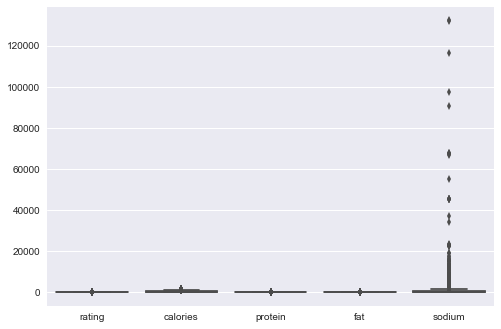

,rating,calories,protein,fat,sodium
count,13678.000,13678.000,13678.000,13678.000,13678.000
mean,3.767,433.254,18.906,24.009,656.551
std,1.263,321.427,24.991,23.090,2897.570
min,0.000,0.000,0.000,0.000,0.000
25%,3.750,205.000,3.000,8.000,89.000
50%,4.375,341.000,9.000,18.000,298.000
75%,4.375,579.000,27.000,32.000,698.000
max,5.000,1796.000,310.000,166.000,132220.000


In [5]:
# Looks like there are duplicates in the set so I will remove them

dfcl = df.drop_duplicates('title',keep='first')

q1  = dfcl['calories'].quantile(.25)
q3  = dfcl['calories'].quantile(.75)
iqr = q3 - q1

dfcl = dfcl.loc[(dfcl['calories'] > q1-(iqr*3)) & (dfcl['calories'] < q3+(iqr*3))]

sns.boxplot(data=dfcl)
plt.show()
dfcl.describe()

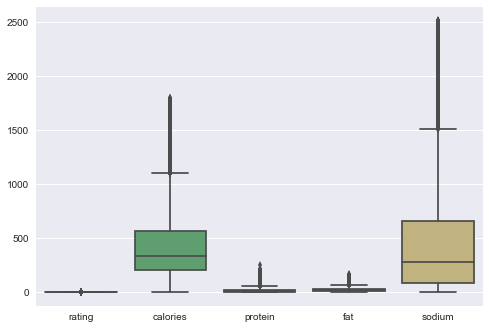

,rating,calories,protein,fat,sodium
count,13314.000,13314.000,13314.000,13314.000,13314.000
mean,3.767,422.713,17.713,23.533,452.748
std,1.258,309.337,22.710,22.633,491.370
min,0.000,0.000,0.000,0.000,0.000
25%,3.750,204.000,3.000,8.000,85.000
50%,4.375,335.000,8.000,17.000,283.000
75%,4.375,563.000,25.000,32.000,655.000
max,5.000,1796.000,253.000,166.000,2513.000


In [7]:
# Drop Sodium > 1870

q1 = dfcl['sodium'].quantile(.25)
q3 = dfcl['sodium'].quantile(.75)
iqr = q3 - q1

dfcl = dfcl.loc[(dfcl['sodium'] > q1-(iqr*3)) & (dfcl['sodium'] < q3+(iqr*3))]

sns.boxplot(data=dfcl)
plt.show()
dfcl.describe()

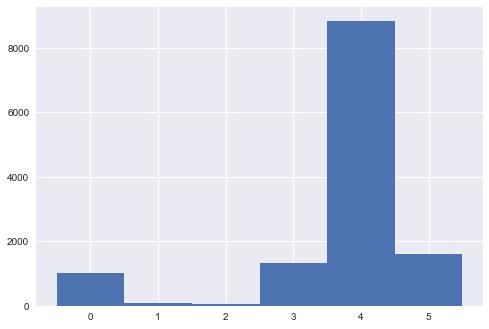

In [21]:
# Look at the distribution of ratings

plt.hist(dfcl['rating'], bins=np.arange(-.5,6.5))
plt.show()

Looking at the histogram above, there are many more values for 0 then would be expected. I'm assuming this is because there are many recipes that do not have any ratings at all. I will drop all recipes which have a rating of 0.

In [8]:
# Drop ratings of 0 (If they have no votes yet)
# Drop recipes where calories = 0 (Because we need fat/calorie ratio)

dfcl = dfcl.drop((dfcl[dfcl['rating'] == 0].index) |
                (dfcl[dfcl['calories'] == 0].index))

# Create columns for fat and protein ratio

dfcl['fat/cal'] = dfcl['fat'] / dfcl['calories']
dfcl['prot/cal'] = dfcl['protein'] / dfcl['calories']

dfcl.describe()

,rating,calories,protein,fat,sodium,fat/cal,prot/cal
count,12279.000,12279.000,12279.000,12279.000,12279.000,12279.000,12279.000
mean,4.083,434.474,18.546,24.427,466.825,0.053,0.038
std,0.651,311.683,23.015,22.736,490.914,0.025,0.030
min,1.250,1.000,0.000,0.000,0.000,0.000,0.000
25%,3.750,214.000,4.000,9.000,99.000,0.038,0.014
50%,4.375,350.000,9.000,18.000,301.000,0.054,0.030
75%,4.375,580.000,27.000,33.000,675.000,0.070,0.054
max,5.000,1796.000,253.000,166.000,2513.000,0.125,0.215


c:\users\abe\appdata\local\programs\python\python36-32\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


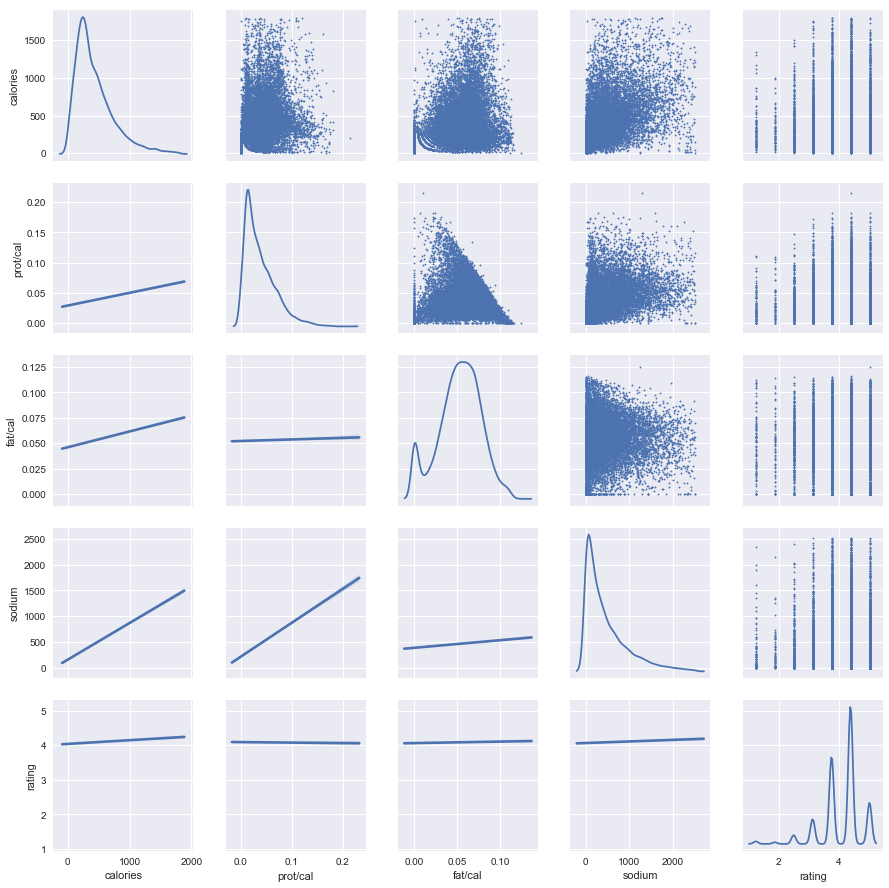

In [9]:
# Take a look at the correlations in our set

columns = ['calories','prot/cal','fat/cal','sodium','rating']
df_ss = dfcl[columns]

g = sns.PairGrid(df_ss, diag_sharey=False)
g.map_upper(plt.scatter, s=2)
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
g.map_diag(sns.kdeplot)
plt.show()

In [10]:
predictors = ['calories','prot/cal','fat/cal','sodium']
predicting = ['rating']

X = df_ss[predictors]
y = df_ss[predicting]

regr = linear_model.LinearRegression()

cross_val_score(regr, X, y, cv=5).mean()

0.002331204495565853

In [11]:
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
cross_val_score(knn, X, y, cv=5).mean()

-0.1022214811362844

## Conclusion

After cleaning the data and fitting both the linear regression and KNN models it looks like the macro nutrient data are not good features to predict the recipe rating. Fat and sodium might be good predictors of *flavor* but not necessarily how good a recipe is. Other features which might be included to better predict the recipe rating could be difficulty, ease of finding ingredients, and how well written the instructions are.